# Model Fairness Testing
Objective #1: Test an example dental model for fairness and biases.

Objective #2: Streamline notebook for reuse when fairness testing of other models.

In [58]:
#General imports
import os
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

#Project specific imports
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    true_positive_rate,
    selection_rate
)
import pickle
import warnings


## local import
from utils import fairness_intervention as fi
from utils import visualisation_functions as vf 
import importlib
importlib.reload(fi)

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

## Getting Started

__Expected Data Format__:
In order to use Fairlearn, we'll need to compare your model's predicted vs actual across different groups so the data coming into this notebook should look something like this:


|column1| column2 | ... | y_true | y_pred
|----|----|----|----|----|
|val|val|...| 1 | 1 |
|val|val|...| 0 | 1 |



__Sections__:
1. Use Case Design
2. Fairness Testing
    - part a: gender
    - part b: race
    - part c: age
    - part d: socioeconomic status
    - part e: geography
    - part f: other sensitive features
3. Other toolings/frameworks to consider



<div class="alert alert-block alert-info">
Pay special attention to Info blocks highlighted in blue. They provide crucial information about fairness testing.
</div>

<div class="alert alert-block alert-success">
Conclusions about some results & other comments will be highlighted in green.
</div>

In [2]:
# Load data
xrays_metadata_loc = '/mnt/azureblobshare/data/raw/nea-dental/final_join_single_crowns_xrays.pkl'
xrays_testpred_loc = 'results.pkl'
xrays_metadata = pd.read_pickle(xrays_metadata_loc)
xrays_testpred = pd.read_pickle(xrays_testpred_loc)

# Join metadata with test set predictions
xrays_metadata = pd.merge(xrays_metadata, xrays_testpred, left_on=  ['Claim ID'],
                   right_on= ['filenames'], 
                   how = 'inner')
xrays_metadata.shape

(8551, 62)

In [ ]:
xrays_metadata[['Claim ID', 'filenames', 'test_y', 'predict_y']].sample(3)

In [18]:
## Do your data filtering here

## drop a row where DOB is falsely entered
xrays_metadata = xrays_metadata[xrays_metadata['PATIENT_DOB'] != ('0001-01-01')]


In [50]:
## Indicate your Actual and Predicted columns & convert them to binary 1s and 0s
y_true = pd.Series(np.where(xrays_metadata['test_y'].values == 1, 1, 0),
          xrays_metadata.index)
y_pred = pd.Series(np.where(xrays_metadata['predict_y'].values >= .99, 1, 0),
          xrays_metadata.index) 


## Section 1. Use Case Design
As part of the AI Review Board process, one of the first thing you will be asked about is the design of your use case. It is good to start out by very clearly defining this. Here are some questions to answer.

#### Question 1. How will the model be used? Including the system in which it will operate and the intended users of the output created by the model.

<div class="alert alert-block alert-success">
The dental model looks at x-ray images, and automatically approve dental claims based on the x-ray. If a claim is not approved by the model, it goes to a human reviewer. This means that we will try to optimize the model's precision by minimizing false positives.
</div>

#### Question 2. Describe the benefits, potential human impacts whether directly or indirectly as a result of using this model.

<div class="alert alert-block alert-success">
The model helps to automate dental claims processing by automatically approving certain claims based on x-ray image data.
</div>

#### Question 3. Identify potential risks that could be created in the case that the ML operates as intended, does not operate as intended, or is misused or abused.

<div class="alert alert-block alert-success">
A high false positive rate in the model may end up costing the company money on claims that shouldn't have been approved.
</div>

## Section 2. Fairness Testing
This section is divided into multiple parts each dealing with different sensitive features.
<div class="alert alert-block alert-info">
Info: Even if your model does not use these sensitive features as input, you still need to test them for fairness because other input features might latently have correlated bias with these sensitive features. For example, dental bitewing X-rays of female vs male will inherently have gender differences because studies show male teeth are statistically larger in size anatomically.
</div>

In [66]:
# utility function to explore metrics by group
def get_metrics_by_group(metrics, group, y_true, y_pred):
    metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=group)

    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title="Show all metrics",
    )

# metrics to explore
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count}

<div class="alert alert-block alert-info">
In general for the metrics, we mainly want to be looking for imbalance in the selection rate, false positive rate, and false negative rate.
    <br><br>
    selection rate: The percentage of data with a positive label within that group.<br>
    false positive rate: The percentage of data that was incorrectly predicted positive.<br>
    false negative rate: The percentage of data that was incorrectly predicted negative.<br>
<br>
For example when analyzing the gender group if we see a high selection rate as well as a high false positive rate for male, that means the model has a incorrect bias toward male.
</div>

### Part a: Gender

<div class="alert alert-block alert-success">
Here is an example of using the gender-guesser library to impute the gender data from patient first name. Self-reported data is always better though, so you should look for ways to obtain it before using imputation methods.
</div>

In [21]:
%%time
import gender_guesser.detector as gg
gd = gg.Detector(case_sensitive=False)

## impute the gender from patient first name
patient_gender = []
for i, row in xrays_metadata.iterrows():
    gender = gd.get_gender(row['PATIENT_FIRST'])
    if gender == "mostly_male":
        gender = "male"
    if gender == "mostly_female":
        gender = "female"
    patient_gender.append(gender)
    
xrays_metadata['patient_gender'] = patient_gender
xrays_metadata[['PATIENT_FIRST', 'patient_gender']].sample(10)

CPU times: user 754 ms, sys: 8.9 ms, total: 763 ms
Wall time: 805 ms


,PATIENT_FIRST,patient_gender
2708,Rine,female
3736,Clark,male
4451,Jerome,male
7636,Surabhi,unknown
2040,Nahim,unknown
1455,PEGGY,female
3823,Maureen,female
3593,Christopher,male
5526,Thomas,male
4410,Michelle,female


<div class="alert alert-block alert-info">
Info: You must exhaust all options to obtain and use self-reported demographic data before resorting to using imputation/inference methods. The use of imputed data should be noted and discussed as part of the AI Review Board process for the particular model being tested.
</div>

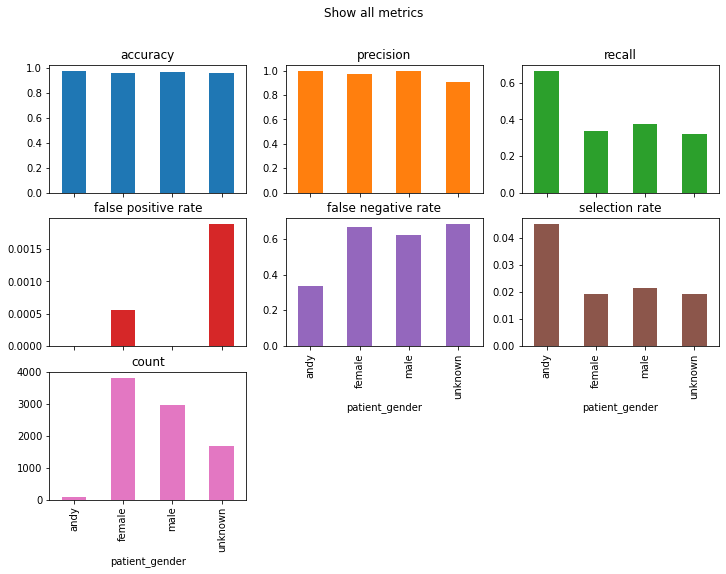

In [67]:
# pick out gender related features for fairlearn
patient_gender = xrays_metadata['patient_gender']

# Get metrics by patient_age_bucket
get_metrics_by_group(metrics=metrics, group=patient_gender, y_true=y_true, y_pred=y_pred)


<div class="alert alert-block alert-success">
For this dental model, we are mainly concerned about imbalance in the false positive rate (FPR) because it may mean that the model is incorrectly favoring a certain group. The model is not penalized for false negatives because it will simply go to a human reviewer.
    <br><br>
There is imbalance in the FPR for "unknown" gender group, however if we look at the scale axis, the rate is 0.1% and it may be small enough that it is negligible. We will have to discuss with business and SME to determine what an acceptable false positive rate threshold will be.
</div>

### Part b: Race


Race data currently unavailable.
Obtaining race data in progress...


### Part c: Age

<div class="alert alert-block alert-info">
Tip: Fairlearn will only work with categorical features, so it's best to first bucket continuous features like age.
</div>

In [23]:
## convert to datetime
xrays_metadata['CREATE_DATE'] = pd.to_datetime(xrays_metadata['CREATE_DATE'])
xrays_metadata['PATIENT_DOB'] = pd.to_datetime(xrays_metadata['PATIENT_DOB'])

## Calculate age using patient date of birth
xrays_metadata['patient_age'] = xrays_metadata['CREATE_DATE']-xrays_metadata['PATIENT_DOB']
xrays_metadata['patient_age'] = xrays_metadata['patient_age'].astype('<m8[Y]')

## create age bucket column
bins = [0, 18, 30, 40, 50, 60, 70, 140]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71+']
xrays_metadata['patient_age_bucket'] = pd.cut(xrays_metadata['patient_age'], bins, labels = labels,include_lowest = True)

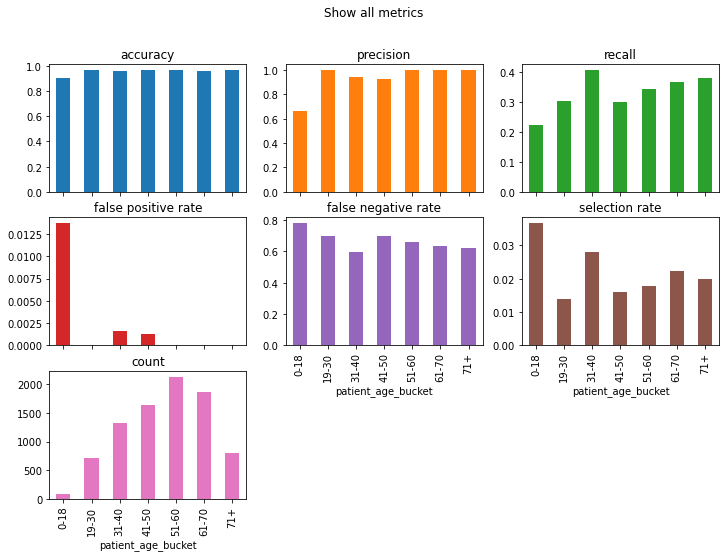

In [52]:
# pick out age related features for fairlearn
patient_age_bucket = xrays_metadata['patient_age_bucket']

# Get metrics by patient_age_bucket
get_metrics_by_group(metrics=metrics, group=patient_age_bucket, y_true=y_true, y_pred=y_pred)


<div class="alert alert-block alert-success">
We see that people under age 18 have a higher false positive rate (FPR) than other age groups.
The rate is roughly 1.25% of people under age 18 will receive a false positive. This may be a significant amount if we're looking at millions of claims.
However, we see that the count distribution in our test set there's not a lot of datapoints for people under age 18.
Let's assume anyways that our model is being unfair between the age groups, and try out some intervention methods. 
</div>

In [63]:
%%time

## create age bucket column based on whether they're above 18 or below 18
bins = [0, 18, 140]
labels = ['18 and under', 'over 18']
xrays_metadata['patient_age_bucket_2'] = pd.cut(xrays_metadata['patient_age'], bins, labels = labels,include_lowest = True)

## compute intervention thresholds
under_18, above_18 = fi.split_test_set_by_binary_category(xrays_metadata, 'patient_age_bucket_2', ['18 and under', 'over 18'])
intervention_results_df = fi.run_algorithmic_interventions_df(
    {'group_0': under_18, 'group_1': above_18},
    {'actuals_col_name': 'test_y', 'predicted_col_name': 'predict_y'},
    {'weight_tp': 1, 'weight_fp': 7},
    thresholds = np.arange(0.00, 1.01, 0.01)
)

CPU times: user 1min 40s, sys: 753 ms, total: 1min 40s
Wall time: 1min 45s


In [64]:
## Group intervention results by methods where they achieved the highest profit
intervention_results_df = intervention_results_df.reset_index(drop=True).round(3)
intervention_results_df['Profit'] = pd.to_numeric(intervention_results_df['Profit'])
max_profits_intervention = intervention_results_df.loc[intervention_results_df.groupby(['IntervationName'])['Profit'].idxmax()]  
max_profits_intervention = max_profits_intervention.sort_values('Profit', ascending=False)
max_profits_intervention.head(100)

,IntervationName,Profit,threshold_0,threshold_1,TruePositive0,FalsePositive0,PositiveRate0,NegativeRate0,TruePositiveRate0,FalsePositiveRate0,TruePositive1,FalsePositive1,PositiveRate1,NegativeRate1,TruePositiveRate1,FalsePositiveRate1
11016,MaxProfit,162,1.00,0.97,0,0,0.000,1.000,0.000,0.000,239,11,0.030,0.970,0.513,0.001
10667,GroupUnawareness,157,0.97,0.97,2,1,0.037,0.963,0.222,0.014,239,11,0.030,0.970,0.513,0.001
9547,DemographicParity,111,0.88,0.93,2,1,0.037,0.963,0.222,0.014,277,23,0.035,0.965,0.594,0.003
7311,EqualOpportunity,46,0.69,0.81,6,1,0.085,0.915,0.667,0.014,313,38,0.041,0.959,0.672,0.005
11023,EqualisedOdds,0,1.00,1.00,0,0,0.000,1.000,0.000,0.000,0,0,0.000,1.000,0.000,0.000


<div class="alert alert-block alert-info">
Info: We see in the dataframe above that different fairness intervention methods applies different thresholds to each group. These thresholds are picked based on the highest profit score from the profit function. Here is a brief description about each intervention methods:
<br><br>
    
- **Maximise profit** uses different classification thresholds for each group and only aims at maximising profit.<br>
- **Fairness through unawareness** uses the same classification threshold for all groups while maximising profit.<br>
- **Demographic parity** applies different classification thresholds for each group, while keeping the same fraction of positives in each group.<br>
- **Equal opportunity** uses different classification thresholds for each group, while keeping the same true positive rate in each group.<br>
- **Equalised odds** applies different classification thresholds for each group, while keeping the same true positive rate and false positive rate in each group.
<br><br>
    
Please read more about these fairness methods here: https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2
    
</div>

In [68]:
from bokeh.plotting import show
from bokeh.io import output_notebook

p = vf.plot_dual_axis_bar_line(
    max_profits_intervention, 
    title="Tradeoffs between Fairness Intervention & Profit",
    groups_name='IntervationName', 
    bar_target_name_variable0='TruePositiveRate0', 
    bar_target_name_variable1="TruePositiveRate1", 
    bar_variables=['18 and under', 'over 18'], 
    line_target_name='Profit', 
    left_axis_y_label='True Positive Rate (TPR)', 
    right_axis_y_label='Profit')

p2 = vf.plot_dual_axis_bar_line(
    max_profits_intervention, 
    title="Tradeoffs between Fairness Intervention & Profit",
    groups_name='IntervationName', 
    bar_target_name_variable0='FalsePositiveRate0', 
    bar_target_name_variable1="FalsePositiveRate1", 
    bar_variables=['18 and under', 'over 18'], 
    line_target_name='Profit', 
    left_axis_y_label='False Positive Rate (FPR)', 
    right_axis_y_label='Profit')

output_notebook()
show(p)
show(p2)

Loading BokehJS ...

![image](images/fairness-tradeoffs.png)
<div class="alert alert-block alert-success">
In the chart above, we can present to business various methods and their potential profit (represented by the yellow line). The profit function was set to heavily penalize false positives. The ideal fairness method for our dental use case would be "Equalised Odds", because it ensures both groups have the same false positive rate. However, in this case it is not ideal to try to achieve equalised odds because the FPR is already so low, and raising the threshold any further would detriment the value of the model.
</div>

### Part d: socioeconomic status


There is no available features or imputation methods for us to analyze socioeconomic status at the moment, so skipping this part ...


### Part e: geography

Found 52 subgroups. Evaluation may be slow


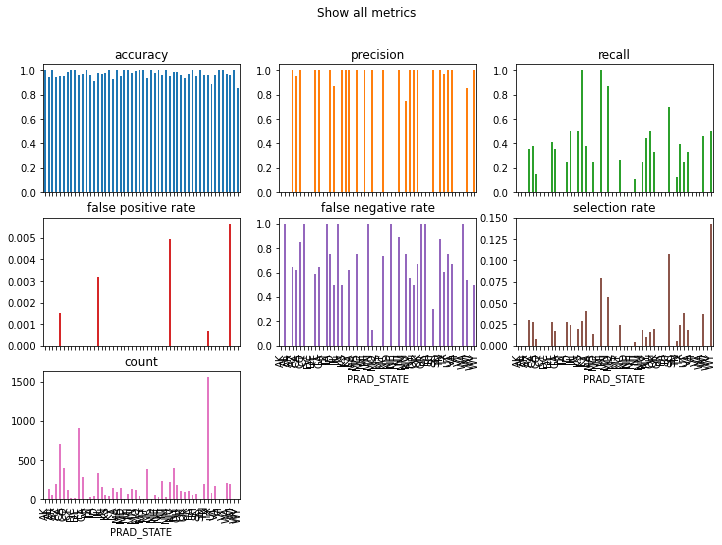

In [27]:
# pick out geography related features
PRAD_STATE = xrays_metadata['PRAD_STATE']

# Get metrics by PRAD_STATE
get_metrics_by_group(metrics=metrics, group=PRAD_STATE, y_true=y_true, y_pred=y_pred)

<div class="alert alert-block alert-success">
Although there is uneven selection rate between different states, as long as the false positive rates do not see imbalance at a significant margin then we are fine since it means that the model is not being affected by this feature.
</div>

### Part f: Other Sensitive Features
It's worth exploring other features to see how your model might be impacted by it.

<div class="alert alert-block alert-info">
Info: Just because a feature has bias, does not mean it is bad. In fact, your ML model benefits from learning the biases within the data. Only the biases that have ethical consequences should be mitigated.
</div>

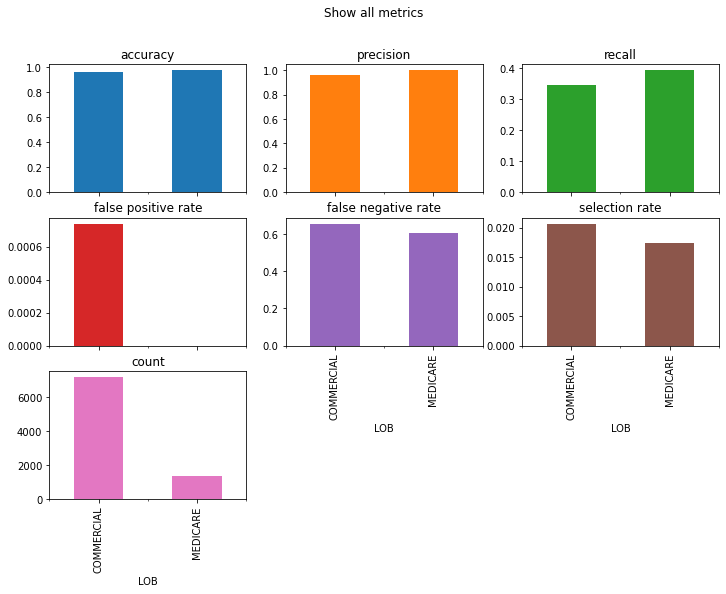

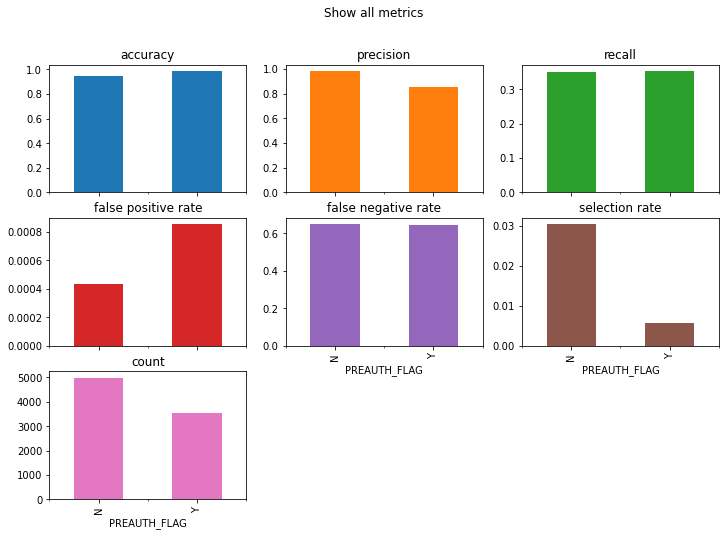

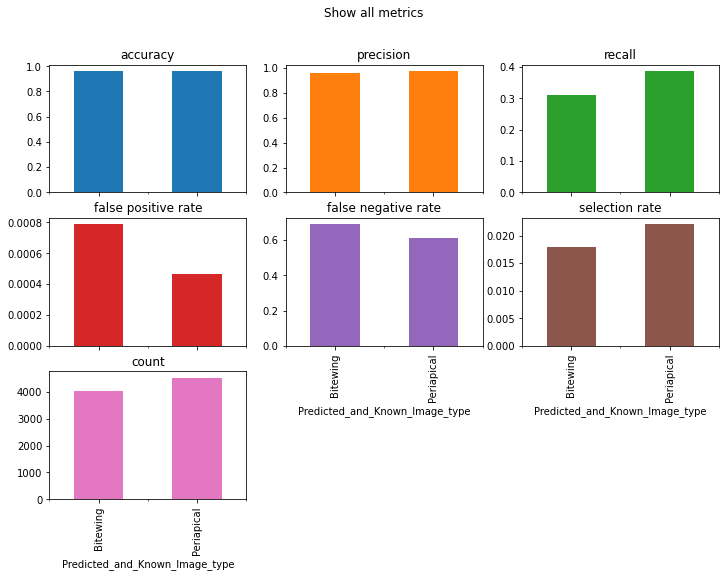

In [28]:
# pick out some other potential sensitive features
LOB = xrays_metadata['LOB']
PREAUTH_FLAG = xrays_metadata['PREAUTH_FLAG']
Predicted_and_Known_Image_type = xrays_metadata['Predicted_and_Known_Image_type']

# Get metrics by LOB
get_metrics_by_group(metrics=metrics, group=LOB, y_true=y_true, y_pred=y_pred)
# Get metrics by PREAUTH_FLAG
get_metrics_by_group(metrics=metrics, group=PREAUTH_FLAG, y_true=y_true, y_pred=y_pred)
# Get metrics by Predicted_and_Known_Image_type
get_metrics_by_group(metrics=metrics, group=Predicted_and_Known_Image_type, y_true=y_true, y_pred=y_pred)


<div class="alert alert-block alert-success">
There is no significant difference between the FPRs for the above categories, so we do not need to worry.
</div>

## Section 3. Other toolings/frameworks to consider
This notebook primarily uses Fairlearn for fairness testing. You can also perform some bias mitigation using fairlearn: https://fairlearn.org/v0.7.0/quickstart.html

Here are just some of other tools for testing and mitigating biases in case you want to take this further:
- FairML for assessing feature dependence: https://github.com/adebayoj/fairml
- Google's Whatif tool for visually exploring biases: https://pair-code.github.io/what-if-tool/


Open Source Datasets for benchmarking imputation/inference methods:
- KBM AmeriLINK: https://uhgazure.sharepoint.com/sites/optumiqstudio/SitePages/Wunderman---KBM--AmeriLINK-.aspx
- NHI Datasets: https://uhgazure.sharepoint.com/sites/optumiqstudio/SitePages/Data-User-Guides.aspx

Python Libraries for Imputation:
- Race Imputation: https://pypi.org/project/ethnicolr/
- Gender Imputation: https://pypi.org/project/gender-guesser/